In [1]:
import time
import glob
import pickle
import numpy as np
import pandas as pd
from pandarallel import pandarallel
# from tqdm import tqdm

from ifloat.usecase.area_evaluator import SplittingGridEvaluator, WholeGridEvaluator, IAreaEvaluator
from ifloat.util.dependency import Dependency
from ifloat.infra.visualizer import visualize_floor, visualize_grid_and_sg
from keras.models import Model,load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Dropout

import tensorflow as tf
from tensorflow.keras import layers, models

from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as animation
from matplotlib.animation import ArtistAnimation
import numpy as np

from ifloat.domain.factory_models import Facility

In [2]:
import numpy as np
from scipy.ndimage import distance_transform_edt

from collections import defaultdict
from scipy import ndimage
import matplotlib.pyplot as plt
def create_bottleneck_map(grid_map):
    """
    通路の幅が狭いセル（ボトルネック）を検出するボトルネックマップを生成
    """
    height, width = grid_map.shape
    bottleneck_map = grid_map.copy().astype(np.float32)

    for y in range(height):  # 全範囲を処理
        for x in range(width):  # 全範囲を処理
            if grid_map[y, x] == 0:  # 通行可能なセルのみを処理

                # 隣接セルを取得（境界セルでは存在しないセルを無視）
                up = grid_map[y-1, x] if y > 0 else 1  # 上のセル、境界では障害物扱い
                down = grid_map[y+1, x] if y < height-1 else 1  # 下のセル
                left = grid_map[y, x-1] if x > 0 else 1  # 左のセル
                right = grid_map[y, x+1] if x < width-1 else 1  # 右のセル

                # 垂直方向のボトルネック検出
                if left == 1 and right == 1 and up == 0 and down == 0:
                    bottleneck_map[y, x] = 0.5

                # 水平方向のボトルネック検出
                elif up == 1 and down == 1 and left == 0 and right == 0:
                    bottleneck_map[y, x] = 0.5

                # # 斜め方向の障害物による狭窄部の検出
                # diagonal_pairs = [
                #     ((y-1, x-1), (y+1, x+1)),  # 左上と右下
                #     ((y-1, x+1), (y+1, x-1))   # 右上と左下
                # ]
                # for (y1, x1), (y2, x2) in diagonal_pairs:
                #     if (0 <= y1 < height and 0 <= x1 < width and
                #         0 <= y2 < height and 0 <= x2 < width):
                #         if (grid_map[y1, x1] == 1 and grid_map[y2, x2] == 1):
                #             bottleneck_map[y, x] = 0.5  # 斜めの狭窄部は弱く強調

    return bottleneck_map

In [3]:
def astar_path_plt(solution):#経路を＋１する関数
    map_height, map_width = 18,18
    
    # レイヤーを作成：マップ + エージェントのスタートとゴール
    
    map = np.zeros((map_height, map_width))
    
    if solution==[]:
        
        return map
    
    for i in range(len(solution)):
        for j in range(len(solution[i])):
            start_x = solution[i][j][1]
            start_y = solution[i][j][2]
        # スタート位置をレイヤーに設定
            map[start_x,start_y] = map[start_x,start_y]+1

    map = map/len(solution)
    return map
def astar_map(sol):
    map_data=[]
    for i in range(len(sol)):
        astar_map = astar_path_plt(sol[i])
        map_data.append(astar_map)
        
    return map_data
        
def bottleneck_map(map_da):
    map_data=[]
    for i in range(len(map_da)):
        bottleneck_map = create_bottleneck_map(map_da[i])
        map_data.append(bottleneck_map)
        
    return map_data

def make_layor(A_map,B_map):
    A_map=np.array(A_map)
    # B_map=np.array(B_map)
    data_number=len(A_map)

    A_map=np.expand_dims(A_map,axis=-1)
    # B_map=np.expand_dims(B_map,axis=-1)
   
    combined_maps = np.zeros((data_number, 18,18, 3))
    
    for i in range(data_number):
        combined_maps[i] = np.concatenate((A_map[i], B_map[i]), axis=-1)
    
    return combined_maps

In [4]:
def generate_distance_map(binary_map, start_point):
    rows, cols = binary_map.shape
    distance_map = np.full((rows, cols), np.inf)
    distance_map[start_point] = 0
    
    # 幅優先探索 (BFS) を使用して距離を計算します
    queue = [start_point]
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),(-1, -1), (-1, 1), (1, -1), (1, 1)]  # 8方向に対応
    
    while queue:
        x, y = queue.pop(0)
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and binary_map[nx, ny] == 0:
                new_distance = distance_map[x, y] + np.sqrt(dx**2 + dy**2)
                if new_distance < distance_map[nx, ny]:
                    distance_map[nx, ny] = new_distance
                    queue.append((nx, ny))
    
    # 障害物 (1) のセルを無限大のままにする
    
    distance_map[binary_map == 1] = 0
    distance_map[np.isinf(distance_map)] = 0
    max_distance=np.max(distance_map)
    distance_map=distance_map/max_distance
    # print(max_distance)
    return distance_map

In [5]:
def astar_each_path_plt(solution):#経路を＋１する関数
    map_height, map_width = 18,18
    
    # レイヤーを作成：マップ + エージェントのスタートとゴール
    agent_num = len(solution)
    map = np.zeros((map_height, map_width,2))
    
    if solution==[]:
        
        return map
    
    for i in range(len(solution)):
        for j in range(len(solution[i])):
            start_x = solution[i][j][1]
            start_y = solution[i][j][2]
        # スタート位置をレイヤーに設定
            map[start_x,start_y,i] = map[start_x,start_y,i]+1

    
    return map

def astar_each_map(sol):
    map_data=[]
    for i in range(len(sol)):
        astar_map = astar_each_path_plt(sol[i])
        map_data.append(astar_map)
        
    return map_data

In [6]:
with open("../data_set/test_label/randam/9map_2/astar/history_label/all_history_label.pkl", "rb") as f:
    astar_sol = pickle.load(f)
    
with open("../data_set/test/randam/9map_2/original_map.pkl", "rb") as f:
    only_map_data = pickle.load(f)
    
# with open("../data_set/test/72bit_cost_only_m.pkl", "rb") as f:
#     test_map_data = pickle.load(f)

In [34]:
print(len(only_map_data))

3000


In [22]:
def distance_map(map_data, starts):
    num_maps = len(map_data)
    num_starts = len(starts)
    map_data = np.array(map_data)
    rows, cols = map_data[0].shape
    distance_map_data = []

    for i in range(num_maps):
        all_distance_maps = np.zeros((rows, cols, num_starts))
        for j in range(num_starts):
            d_map_data = generate_distance_map(map_data[i], starts[j])
            all_distance_maps[:, :, j] = d_map_data
        
        distance_map_data.append(all_distance_maps)
    
    return distance_map_data
            

In [35]:
start_point=(0,0)
m=only_map_data[2140:2142]

starts=[(35,0),(35,71),(0,0),(71,71)]
goals=[(35,71),(35,0),(71,71),(0,0)]
# starts=[(17,0),(17,35),(0,0),(35,35)]
# goals=[(17,35),(17,0),(35,35),(0,0)]
# starts=[(8,0),(8,17),(0,0),(17,17)]
# goals=[(8,17),(8,0),(17,17),(0,0)]
distance_map_data=distance_map(m,starts)
print(len(distance_map_data[0][0][0]))
distance_map_data=np.array(distance_map_data)
visualize_grid_and_sg(distance_map_data[1,:,:,3], starts, goals, size_inch=5.0)
print(distance_map_data)


IndexError: index 35 is out of bounds for axis 0 with size 18

In [133]:
print(len(starts))

2


In [7]:
only_map_data=np.array(only_map_data)

In [12]:
astar_map_data = astar_map(astar_sol)
bottleneck_map_data = bottleneck_map(only_map_data)
# test_bottleneck_map_data = bottleneck_map(test_map_data)

conbine_map = make_layor(bottleneck_map_data,astar_map_data)

print(conbine_map[0].shape)

conbine_astar_map = make_layor(only_map_data,astar_map_data)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [24]:
print(astar_map_data[0].shape)

(18, 18, 2)


In [28]:
astar_map_data = astar_each_map(astar_sol)
bottleneck_map_data = bottleneck_map(only_map_data)
# test_bottleneck_map_data = bottleneck_map(test_map_data)
conbine_map = make_layor(bottleneck_map_data,astar_map_data)


print(conbine_map[0].shape)

conbine_astar_map = make_layor(only_map_data,astar_map_data)

TypeError: 'list' object is not callable

In [10]:
with open("../data_set/test/randam/9map_2/astar_map.pkl", "wb") as f:
    pickle.dump(astar_map_data, f)
    
with open("../data_set/test/randam/9map_2/bottleneck_map.pkl", "wb") as f:
    pickle.dump(bottleneck_map_data, f)

with open("../data_set/test/randam/9map_2/conbine_map.pkl", "wb") as f:
    pickle.dump(conbine_map, f)
    
with open("../data_set/test/randam/9map_2/conbine_astar_map.pkl", "wb") as f:
    pickle.dump(conbine_astar_map, f)
    


In [11]:
with open("../data_set/test/randam/9map_2/each_astar_map.pkl", "wb") as f:
    pickle.dump(astar_map_data, f)
    
with open("../data_set/test/randam/9map_2/bottleneck_map.pkl", "wb") as f:
    pickle.dump(bottleneck_map_data, f)

with open("../data_set/test/randam/9map_2/each_conbine_map.pkl", "wb") as f:
    pickle.dump(conbine_map, f)
    
with open("../data_set/test/randam/9map_2/each_conbine_astar_map.pkl", "wb") as f:
    pickle.dump(conbine_astar_map, f)

[(12, 14), (7, 16)]
36


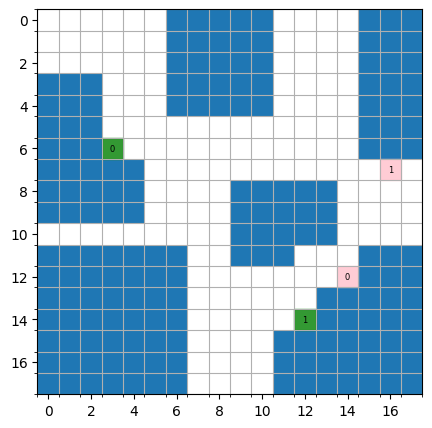

In [5]:
with open("../data_set/training/9map/all_map.pkl", "rb") as f:
    m=pickle.load(f)
with open("../data_set/training/9map_2/notinf_map_data.pkl", "rb") as f:
    ma=pickle.load(f)
with open("../data_set/training/randam/9map_2/each_conbine_astar_map.pkl", "rb") as f:
    conbine_astar_map=pickle.load(f)
with open(f"../data_set/training_label/9map_2/notinf_cost_labels.pkl", "rb") as f:
    cost_label=pickle.load(f) 
with open("../data_set/training/9map/all_start.pkl", "rb") as f:
    starts = pickle.load(f)
with open("../data_set/training/9map/all_goal.pkl", "rb") as f:
    goals = pickle.load(f)
    

    
k=4579
m=m[k]
starts=starts[k]
goals=goals[k]
# a1=conbine_astar_map[k]*2
# a2=conbine_astar_map[k]*0.3

# m=a1[:,:,1]+a2[:,:,2]+m
# starts=[(17,0),(17,35),(0,0),(35,35)]
# goals=[(17,35),(17,0),(35,35),(0,0)]
print(goals)
# starts=[]
# goals=[]
# print(m[:,:,2])
print(cost_label[k])
visualize_grid_and_sg(m[:,:], starts, goals, size_inch=5.0)

In [45]:
m=conbine_map[9996]

m1=m[:,:,0]
m1=m1.reshape((18,18))

starts=[[71,0],[71,71]]
goals=[[71,71],[71,0]]
visualize_grid_and_sg(m1, starts, goals, size_inch=5.0)

starts=[[35,0],[35,71]]
goals=[[35,71],[35,0]]
# m=only_map_data[5]+astar_map_data[5]*2

m2=m[:,:,1]*2

visualize_grid_and_sg(m, starts, goals, size_inch=5.0)

IndexError: index 9996 is out of bounds for axis 0 with size 3000

In [10]:
from mlmodel.mk_model import create_map_with_agents_sg2chanel
filter_cost=[]
filter_map=[]
# starts=[(0,0),(17,17)]
# goals=[(17,17),(0,0)]
# starts=[(17,0),(17,35),(0,0),(35,35)]
# goals=[(17,35),(17,0),(35,35),(0,0)]
# starts=[(35,0),(35,71),(0,0),(71,71)]
# goals=[(35,71),(35,0),(71,71),(0,0)]

filter_astar_cost=[]
crash_diff=[]

with open("../data_set/training/9map/all_map.pkl", "rb") as f:
    only_map_data = pickle.load(f)
    
with open("../data_set/training/9map/all_start.pkl", "rb") as f:
    starts = pickle.load(f)
with open("../data_set/training/9map/all_goal.pkl", "rb") as f:
    goals = pickle.load(f)
    

    
in_deep_data=[]
    
for i in range(len(only_map_data)):
        
        map_with =create_map_with_agents_sg2chanel(only_map_data[i],starts[i],goals[i])

        in_deep_data.append(map_with)   
        
bottle_in_deep_data=[]

with open(f"../data_set/training/randam/9map_2/bottleneck_map.pkl", "rb") as f:
    bottleneck_map=pickle.load(f) 
    
for i in range(len(only_map_data)):
        
        map_with =create_map_with_agents_sg2chanel(bottleneck_map[i],starts[i],goals[i])

        bottle_in_deep_data.append(map_with)   
        
with open(f"../data_set/training_label/randam/9map_2/cost_labels.pkl", "rb") as f:
    cost_label=pickle.load(f) 
        
with open(f"../data_set/training_label/randam/9map_2/astar/astar_cost_label.pkl","rb") as f:
    astar_cost=pickle.load(f)
    
with open("../data_set/training/randam/9map_2/conbine_map.pkl", "rb") as f:
    conbine_map=pickle.load(f)
    
with open("../data_set/training/randam/9map_2/conbine_astar_map.pkl", "rb") as f:
    conbine_astar_map=pickle.load(f)
    
with open("../data_set/training/randam/9map_2/each_conbine_map.pkl", "rb") as f:
    each_conbine_map=pickle.load(f)
    
with open("../data_set/training/randam/9map_2/each_conbine_astar_map.pkl", "rb") as f:
    each_conbine_astar_map=pickle.load(f)

map_data=[]
filter_astar_conbine=[]
filter_conbine_map=[]
filter_deep_data=[]
filter_bottle_conbine=[]
filter_each_conbine_map=[]
filter_each_conbine_astar_map=[]
counter=0
for i in range(40000):
    # print(cost_label[i],astar_cost[i]+4)
    if astar_cost[i]!=np.inf:
        if cost_label[i]!=-1:
            astar_cost[i]=astar_cost[i]-2
            filter_cost.append(cost_label[i])
            filter_map.append(only_map_data[i])
            filter_astar_cost.append(astar_cost[i])
            filter_conbine_map.append(conbine_map[i])
            diff=cost_label[i]-astar_cost[i]
            map_data.append(only_map_data[i])
            filter_astar_conbine.append(conbine_astar_map[i])
            filter_bottle_conbine.append(bottle_in_deep_data[i])
            filter_deep_data.append(in_deep_data[i])
            filter_each_conbine_map.append(each_conbine_map[i])
            filter_each_conbine_astar_map.append(each_conbine_astar_map[i])
            # counter=counter+1
            crash_diff.append(diff)
            if diff !=0:
                print(diff)
                print(cost_label[i],astar_cost[i])
                counter=counter+1
        
        
        
print(counter)
        
with open(f"../data_set/training_label/randam/9map_2/notinf_cost_labels.pkl", "wb") as f:
    pickle.dump(filter_cost, f)  
   
with open(f"../data_set/training/randam/9map_2/notinf_map_data.pkl", "wb") as f:
    pickle.dump(map_data, f)  


with open(f"../data_set/training_label/randam/9map_2/astar/notinf_cost_labels.pkl", "wb") as f:
    pickle.dump(filter_astar_cost, f)  
    
with open(f"../data_set/training_label/randam/9map_2/astar/astar_cost_diff.pkl", "wb") as f:
    pickle.dump(crash_diff, f)
    
with open(f"../data_set/training/randam/9map_2/filter_conbine_map.pkl", "wb") as f:
    pickle.dump(filter_conbine_map, f)
    
with open(f"../data_set/training/randam/9map_2/filter_conbine_astar_map.pkl", "wb") as f:
    pickle.dump(filter_astar_conbine, f)
    
with open(f"../data_set/training/randam/9map_2/notinf_bottleneck_map.pkl", "wb") as f:
    pickle.dump(filter_bottle_conbine, f)  
    
with open(f"../data_set/training/randam/9map_2/notinf_deep_map.pkl", "wb") as f:
    pickle.dump(filter_deep_data, f)  
    
with open(f"../data_set/training/randam/9map_2/filter_each_conbine_map.pkl", "wb") as f:
    pickle.dump(filter_each_conbine_map, f)
    
with open(f"../data_set/training/randam/9map_2/filter_each_conbine_astar_map.pkl", "wb") as f:
    pickle.dump(filter_each_conbine_astar_map, f)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
3
59 56
3
59 56
3
59 56
3
59 56
5
56 51
5
56 51
5
56 51
5
56 51
2
38 36
2
38 36
2
38 36
2
38 36
2
26 24
2
26 24
2
26 24
2
26 24
10
49 39
10
49 39
10
49 39
10
49 39
1
24 23
1
24 23
1
24 23
1
24 23
11
27 16
11
27 16
11
27 16
11
27 16
2
35 33
2
35 33
2
35 33
2
35 33
2
38 36
2
38 36
2
38 36
2
38 36
5
62 57
5
62 57
5
62 57
5
62 57
2
41 39
2
41 39
2
41 39
2
41 39
2
47 45
2
47 45
2
47 45
2
47 45
3
32 29
3
32 29
3
32 29
3
32 29
2
39 37
2
39 37
2
39 37
2
39 37
2
32 30
2
32 30
2
32 30
2
32 30
3
50 47
3
50 47
3
50 47
3
50 47
8
22 14
8
22 14
8
22 14
8
22 14
2
43 41
2
43 41
2
43 41
2
43 41
2
22 20
2
22 20
2
22 20
2
22 20
1
31 30
1
31 30
1
31 30
1
31 30
3
35 32
3
35 32
3
35 32
3
35 32
11
50 39
11
50 39
11
50 39
11
50 39
3
47 44
3
47 44
3
47 44
3
47 44
1
34 33
1
34 33
1
34 33
1


In [13]:
from mlmodel.mk_model import create_map_with_agents_sg2chanel
filter_cost=[]
filter_map=[]
# starts=[(0,0),(17,17)]
# goals=[(17,17),(0,0)]
# starts=[(17,0),(17,35),(0,0),(35,35)]
# goals=[(17,35),(17,0),(35,35),(0,0)]
# starts=[(35,0),(35,71),(0,0),(71,71)]
# goals=[(35,71),(35,0),(71,71),(0,0)]

filter_astar_cost=[]
crash_diff=[]

with open("../data_set/test/randam/9map_2/original_map.pkl", "rb") as f:
    only_map_data = pickle.load(f)
    
with open("../data_set/test/randam/9map_2/original_start.pkl", "rb") as f:
    starts = pickle.load(f)
with open("../data_set/test/randam/9map_2/original_goal.pkl", "rb") as f:
    goals = pickle.load(f)
    
print(len(only_map_data))

    
in_deep_data=[]
    
for i in range(len(only_map_data)):
        
        map_with =create_map_with_agents_sg2chanel(only_map_data[i],starts[i],goals[i])

        in_deep_data.append(map_with)   
        
bottle_in_deep_data=[]

with open(f"../data_set/test/randam/9map_2/bottleneck_map.pkl", "rb") as f:
    bottleneck_map=pickle.load(f) 
    
for i in range(len(only_map_data)):
        
        map_with =create_map_with_agents_sg2chanel(bottleneck_map[i],starts[i],goals[i])

        bottle_in_deep_data.append(map_with)   
         

with open(f"../data_set/test_label/randam/9map_2/cost_labels.pkl", "rb") as f:
    cost_label=pickle.load(f) 
        
with open(f"../data_set/test_label/randam/9map_2/astar/astar_cost_label.pkl","rb") as f:
    astar_cost=pickle.load(f)
    
with open("../data_set/test/randam/9map_2/conbine_map.pkl", "rb") as f:
    conbine_map=pickle.load(f)
    
with open("../data_set/test/randam/9map_2/conbine_astar_map.pkl", "rb") as f:
    conbine_astar_map=pickle.load(f)
    
with open("../data_set/test/randam/9map_2/each_conbine_map.pkl", "rb") as f:
    each_conbine_map=pickle.load(f)
    
with open("../data_set/test/randam/9map_2/each_conbine_astar_map.pkl", "rb") as f:
    each_conbine_astar_map=pickle.load(f)
    
map_data=[]
filter_astar_conbine=[]
filter_conbine_map=[]
filter_deep_data=[]
filter_bottle_conbine=[]
filter_each_conbine_map=[]
filter_each_conbine_astar_map=[]
counter=0
for i in range(3000):
    # print(cost_label[i],astar_cost[i]+4)
    if astar_cost[i]!=np.inf:
        if cost_label[i]!=-1:
            astar_cost[i]=astar_cost[i]-2
            filter_cost.append(cost_label[i])
            filter_map.append(only_map_data[i])
            filter_astar_cost.append(astar_cost[i])
            filter_conbine_map.append(conbine_map[i])
            diff=cost_label[i]-astar_cost[i]
            map_data.append(only_map_data[i])
            filter_deep_data.append(in_deep_data[i])
            filter_bottle_conbine.append(bottle_in_deep_data[i])
            filter_astar_conbine.append(conbine_astar_map[i])
            filter_each_conbine_map.append(each_conbine_map[i])
            filter_each_conbine_astar_map.append(each_conbine_astar_map[i])
            crash_diff.append(diff)
            if diff !=0:
                print(diff)
                print(cost_label[i],astar_cost[i])
                counter=counter+1
        
        
        
print(counter)
        
with open(f"../data_set/test_label/randam/9map_2/notinf_cost_labels.pkl", "wb") as f:
    pickle.dump(filter_cost, f)  
    
with open(f"../data_set/test/randam/9map_2/notinf_map_data.pkl", "wb") as f:
    pickle.dump(map_data, f)  


with open(f"../data_set/test_label/randam/9map_2/astar/notinf_cost_labels.pkl", "wb") as f:
    pickle.dump(filter_astar_cost, f)  
    
with open(f"../data_set/test_label/randam/9map_2/astar/astar_cost_diff.pkl", "wb") as f:
    pickle.dump(crash_diff, f)
    
with open(f"../data_set/test/randam/9map_2/filter_conbine_map.pkl", "wb") as f:
    pickle.dump(filter_conbine_map, f)
    
with open(f"../data_set/test/randam/9map_2/filter_conbine_astar_map.pkl", "wb") as f:
    pickle.dump(filter_astar_conbine, f)
    
with open(f"../data_set/test/randam/9map_2/notinf_bottleneck_map.pkl", "wb") as f:
    pickle.dump(filter_bottle_conbine, f)  
    
with open(f"../data_set/test/randam/9map_2/notinf_deep_map.pkl", "wb") as f:
    pickle.dump(filter_deep_data, f)  
    
with open(f"../data_set/test/randam/9map_2/filter_each_conbine_map.pkl", "wb") as f:
    pickle.dump(filter_each_conbine_map, f)
    
with open(f"../data_set/test/randam/9map_2/filter_each_conbine_astar_map.pkl", "wb") as f:
    pickle.dump(filter_each_conbine_astar_map, f)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
3000
2
28 26
4
29 25
1
23 22
1
58 57
5
46 41
6
51 45
11
45 34
1
41 40
3
56 53
2
26 24
2
41 39
2
62 60
1
40 39
11
40 29
1
25 24
5
28 23
3
18 15
2
34 32
4
47 43
2
33 31
2
41 39
2
32 30
5
55 50
1
37 36
1
36 35
2
39 37
2
29 27
1
48 47
2
42 40
1
31 30
2
45 43
4
28 24
9
26 17
1
35 34
2
43 41
3
52 49
5
56 51
7
52 45
2
37 35
2
57 55
2
37 35
1
30 29
1
44 43
10
25 15
4
31 27
3
36 33
3
58 55
9
23 14
2
42 40
3
43 40
3
25 22
2
54 52
2
31 29
1
28 27
1
40 39
2
41 39
2
37 35
2
40 38
1
33 32
17
47 30
2
32 30
2
43 41
2
42 40
9
38 29
2
59 57
12
47 35
4
40 36
2
60 58
1
27 26
2
54 52
2
60 58
5
45 40
3
58 55
1
49 48
2
42 40
3
58 55
1
33 32
1
38 37
2
42 40
1
26 25
1
28 27
2
27 25
2
37 35
4
58 54
4
32 28
2
24 22
2
31 29
2
26 24
3
27 24
2
45 43
3
59 56
2
27 25
2
54 52
2
34 32
2
56 54
5
67

In [17]:
print(len(filter_each_conbine_map[0][0][0]))

3


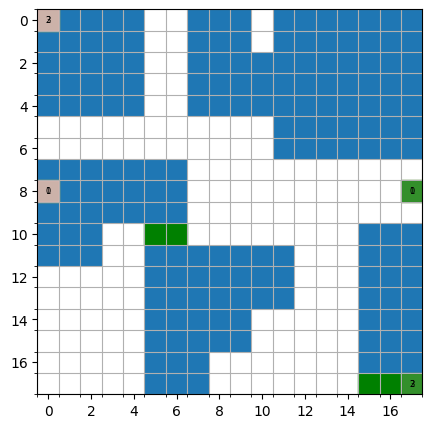

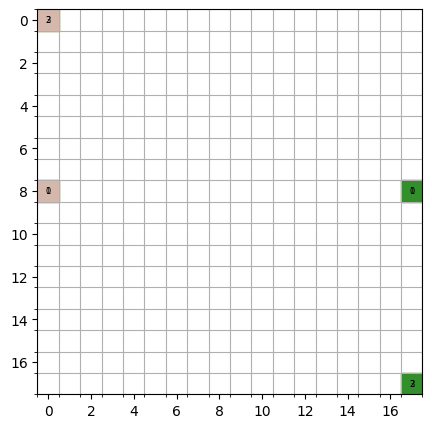

In [36]:
m=conbine_map[15]

m1=m[:,:,0]
m1=m1.reshape((18,18))

starts=[(8,0),(8,17),(0,0),(17,17)]
goals=[(8,17),(8,0),(17,17),(0,0)]
visualize_grid_and_sg(m1, starts, goals, size_inch=5.0)

# starts=[[35,0],[35,71]]
# goals=[[35,71],[35,0]]
# m=astar_map_data[2]

m2=m[:,:,1]

visualize_grid_and_sg(m2, starts, goals, size_inch=5.0)

In [22]:
with open(f"../data_set/training/randam/9map_2/notinf_map_data.pkl", "rb") as f:
    map_data=pickle.load(f)
# starts=[(35,0),(35,71),(0,0),(71,71)]
# goals=[(35,71),(35,0),(71,71),(0,0)]
starts=[(8,0),(8,17)]
goals=[(8,17),(8,0)]
distance_map_data=distance_map(map_data,starts)
with open("../data_set/training/randam/9map_2/distance_map.pkl","wb") as f:
    pickle.dump(distance_map_data,f)

In [23]:
def make_layor_2(A_map,B_map):
    A_map=np.array(A_map)
    B_map=np.array(B_map)
    data_number=len(A_map)

    A_map=np.expand_dims(A_map,axis=-1)
    # B_map=np.expand_dims(B_map,axis=-1)
   
    combined_maps = np.zeros((data_number, 18,18, 3))
    
    for i in range(data_number):
        combined_maps[i] = np.concatenate((A_map[i], B_map[i]), axis=-1)
    
    return combined_maps

def make_layor_mix(A_map,B_map):
    A_map=np.array(A_map)
    B_map=np.array(B_map)
    data_number=len(A_map)

    # A_map=np.expand_dims(A_map,axis=-1)
    # B_map=np.expand_dims(B_map,axis=-1)
   
    combined_maps = np.zeros((data_number, 18,18, 4))
    
    for i in range(data_number):
        combined_maps[i] = np.concatenate((A_map[i], B_map[i]), axis=-1)
    
    return combined_maps

In [24]:
with open(f"../data_set/training/randam/9map_2/notinf_map_data.pkl", "rb") as f:
    map_data=pickle.load(f)
    
with open("../data_set/training/randam/9map_2/distance_map.pkl","rb") as f:
    distance_map_data=pickle.load(f)

with open("../data_set/training/randam/9map_2/filter_conbine_map.pkl","rb") as f:
    conbine_map=pickle.load(f)
    
conb_distance_map=make_layor_2(map_data,distance_map_data)
mix_distance_map=make_layor_mix(conbine_map,distance_map_data)

with open("../data_set/training/randam/9map_2/filter_distance_map.pkl","wb") as f:
    pickle.dump(conb_distance_map,f)
with open("../data_set/training/randam/9map_2/filter_mix_map.pkl","wb") as f:
    pickle.dump(mix_distance_map,f)

In [ ]:
with open("../data_set/test/randam/9map_2/filter_conbine_map.pkl", "rb") as f:
    m=pickle.load(f)
    
m=m[200]
# starts=[(17,0),(17,35),(0,0),(35,35)]
# goals=[(17,35),(17,0),(35,35),(0,0)]
starts=[(8,0),(8,17)]
goals=[(8,17),(8,0)]
# print(m[:,:,2])
visualize_grid_and_sg(m[:,:,1], starts, goals, size_inch=5.0)
visualize_grid_and_sg(m[:,:,0], starts, goals, size_inch=5.0)